In [17]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
# import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [19]:
# main_path = "/content/drive/MyDrive/Computational Medicine Project/chest_xray/"
main_path = "chest_xray/"


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [20]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

orig_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
orig_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [5]:
orig_train

,class,image
0,Normal,chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg
1,Normal,chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg
2,Normal,chest_xray/train/NORMAL/IM-0427-0001.jpeg
3,Normal,chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg
4,Normal,chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg
...,...,...
5211,Pneumonia,chest_xray/train/PNEUMONIA/person142_virus_288.jpeg
5212,Pneumonia,chest_xray/train/PNEUMONIA/person364_bacteria_1659.jpeg
5213,Pneumonia,chest_xray/train/PNEUMONIA/person1323_virus_2283.jpeg
5214,Pneumonia,chest_xray/train/PNEUMONIA/person772_virus_1401.jpeg


In [6]:
df_test

,class,image
0,Normal,chest_xray/test/NORMAL/IM-0031-0001.jpeg
1,Normal,chest_xray/test/NORMAL/IM-0025-0001.jpeg
2,Normal,chest_xray/test/NORMAL/NORMAL2-IM-0272-0001.jpeg
3,Normal,chest_xray/test/NORMAL/NORMAL2-IM-0102-0001.jpeg
4,Normal,chest_xray/test/NORMAL/NORMAL2-IM-0229-0001.jpeg
...,...,...
619,Pneumonia,chest_xray/test/PNEUMONIA/person120_bacteria_572.jpeg
620,Pneumonia,chest_xray/test/PNEUMONIA/person171_bacteria_826.jpeg
621,Pneumonia,chest_xray/test/PNEUMONIA/person109_bacteria_512.jpeg
622,Pneumonia,chest_xray/test/PNEUMONIA/person83_bacteria_410.jpeg


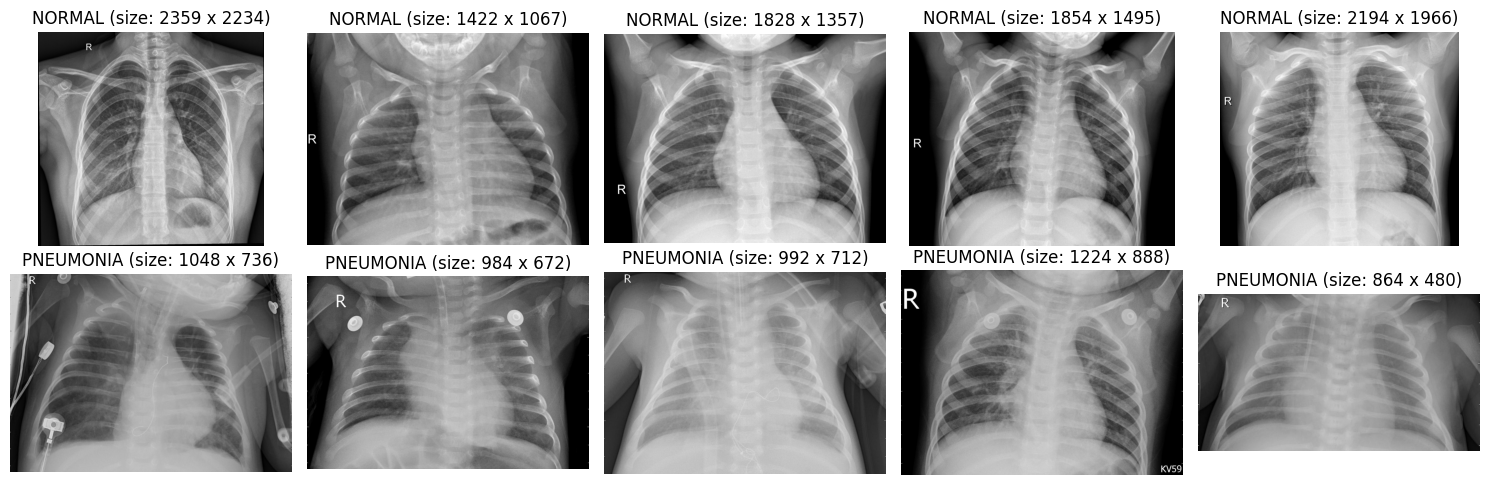

In [21]:
import matplotlib.pyplot as plt
import os
from PIL import Image

normal_directory = 'chest_xray/train/NORMAL/'
pneumonia_directory = 'chest_xray/train/PNEUMONIA/'

# Get the first 5 JPEG images in the NORMAL directory
normal_image_files = [file for file in os.listdir(normal_directory) if file.endswith('.jpeg')][:5]

# Get the first 5 JPEG images in the PNEUMONIA directory
pneumonia_image_files = [file for file in os.listdir(pneumonia_directory) if file.endswith('.jpeg')][:5]

fig, axes = plt.subplots(2, 5, figsize=(15, 5))

# NORMAL images
for i, file_name in enumerate(normal_image_files):
    file_path = os.path.join(normal_directory, file_name)
    img = Image.open(file_path).convert('RGB')  # Ensure image is in RGB mode
    axes[0, i].imshow(img)
    width, height = img.size
    axes[0, i].set_title(f'NORMAL (size: {width} x {height})')
    axes[0, i].axis('off')

# PNEUMONIA images
for i, file_name in enumerate(pneumonia_image_files):
    file_path = os.path.join(pneumonia_directory, file_name)
    img = Image.open(file_path).convert('RGB')  # Ensure image is in RGB mode
    axes[1, i].imshow(img)
    width, height = img.size
    axes[1, i].set_title(f'PNEUMONIA (size: {width} x {height})')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


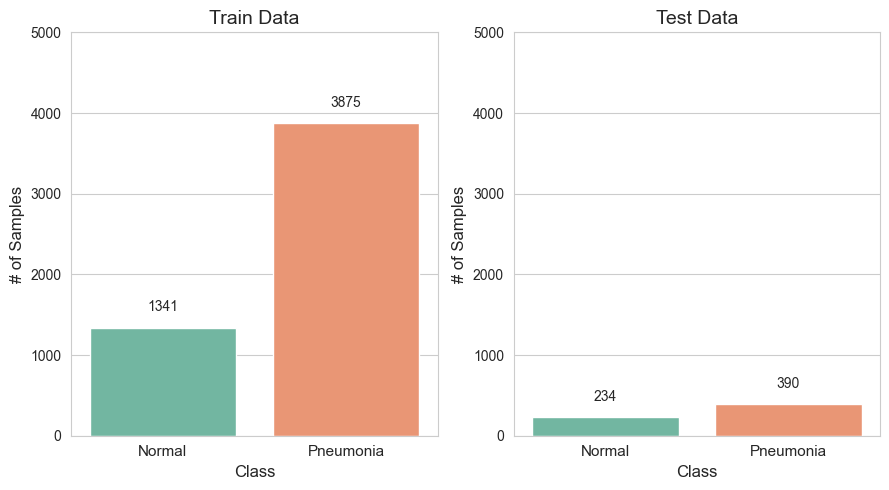

In [22]:
plt.figure(figsize=(9, 5))
sns.set_style("whitegrid")

# First subplot using data from orig_train
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
ax1 = sns.countplot(x='class', data=orig_train, palette="Set2")

plt.title("Train Data", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("# of Samples", fontsize=12)
plt.ylim(0, 5000)

class_labels = ['Normal', 'Pneumonia']
plt.xticks([0, 1], class_labels, fontsize=11)

for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width() / 2., height + 200, f"{int(height)}", ha="center", fontsize=10)

# Second subplot using data from df_test
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
ax2 = sns.countplot(x='class', data=df_test, palette="Set2")

plt.title("Test Data", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("# of Samples", fontsize=12)
plt.ylim(0, 5000)

class_labels = ['Normal', 'Pneumonia']
plt.xticks([0, 1], class_labels, fontsize=11)

for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x() + p.get_width() / 2., height + 200, f"{int(height)}", ha="center", fontsize=10)

plt.tight_layout()
plt.show()


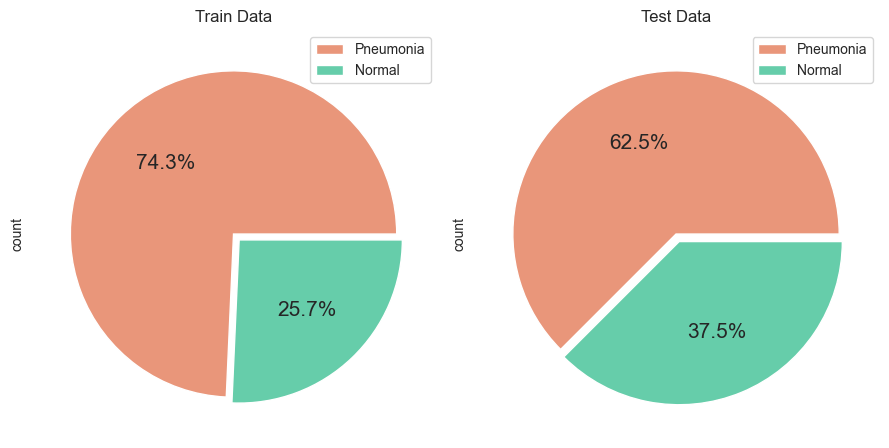

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))

# First subplot using data from orig_train
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
orig_train['class'].value_counts().plot(kind='pie', labels=['', ''], autopct='%1.1f%%',
                                      colors=['darksalmon', 'mediumaquamarine'], explode=[0, 0.05],
                                      textprops={"fontsize": 15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.title('Train Data')

# Second subplot using data from df_test
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
df_test['class'].value_counts().plot(kind='pie', labels=['', ''], autopct='%1.1f%%',
                                     colors=['darksalmon', 'mediumaquamarine'], explode=[0, 0.05],
                                     textprops={"fontsize": 15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.title('Test Data')

plt.tight_layout()
plt.show()


In [24]:
#20% of the data will be used for validation, and the remaining 80% will be used for training
orig_train.loc[orig_train["class"] == "Normal", "class"] = "0"
orig_train.loc[orig_train["class"] == "Pneumonia", "class"] = "1"
train_df, val_df = train_test_split(orig_train, test_size = 0.20, random_state = SEED, stratify = orig_train['class'])

In [ ]:
# orig_train
train_df

In [25]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
d1 = dict()
class_labels = orig_train['class'].values

# Get unique classes and their counts
classes, counts = np.unique(class_labels, return_counts=True)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=classes, y=class_labels)
class_weight_dict = dict(zip(classes, class_weights))
# d = {'Normal':0, 'Pneumonia':1}
# d1 = dict((d[key], value) for (key, value) in class_weight_dict.items())
# class_weight_dict = d1
class_weight_dict
#Normal is 0, Pheumonia is 1

{'0': 1.9448173005219984, '1': 0.6730322580645162}

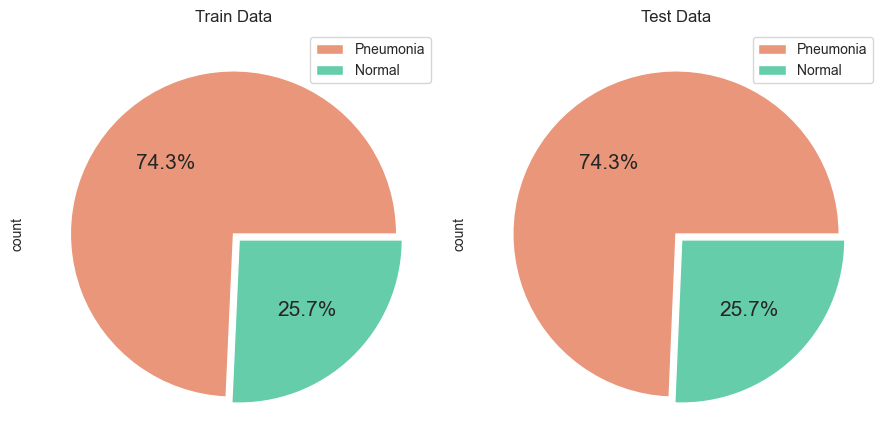

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))

# First subplot using data from orig_train
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
train_df['class'].value_counts().plot(kind='pie', labels=['', ''], autopct='%1.1f%%',
                                      colors=['darksalmon', 'mediumaquamarine'], explode=[0, 0.05],
                                      textprops={"fontsize": 15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.title('Train Data')

# Second subplot using data from df_test
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
val_df['class'].value_counts().plot(kind='pie', labels=['', ''], autopct='%1.1f%%',
                                     colors=['darksalmon', 'mediumaquamarine'], explode=[0, 0.05],
                                     textprops={"fontsize": 15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.title('Test Data')

plt.tight_layout()
plt.show()


,class,image
99,Normal,chest_xray/train/NORMAL/IM-0502-0001.jpeg
1284,Normal,chest_xray/train/NORMAL/IM-0513-0001.jpeg
5142,Pneumonia,chest_xray/train/PNEUMONIA/person797_virus_1429.jpeg
1365,Pneumonia,chest_xray/train/PNEUMONIA/person1812_bacteria_4667.jpeg
2649,Pneumonia,chest_xray/train/PNEUMONIA/person2_bacteria_3.jpeg
...,...,...
4481,Pneumonia,chest_xray/train/PNEUMONIA/person1142_bacteria_3086.jpeg
2404,Pneumonia,chest_xray/train/PNEUMONIA/person568_bacteria_2359.jpeg
705,Normal,chest_xray/train/NORMAL/NORMAL2-IM-0995-0001-0002.jpeg
3732,Pneumonia,chest_xray/train/PNEUMONIA/person796_virus_1428.jpeg


In [27]:
#ImageDataGenerator generates new transformed images by augmenting the original images
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,)
                                  # width_shift_range = 0.1,
                                  # height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

test_datagen = ImageDataGenerator(rescale=1/255.)
#The flow_from_dataframe() method takes the Pandas DataFrame and the path to a directory and generates
#batches of augmented/normalized data
ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = test_datagen.flow_from_dataframe(df_test,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [28]:
#Setting callbacks
#Stop training when a monitored metric has stopped improving.
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,
    patience = 2,
    min_delt = 1e-7,
    cooldown = 0,
    verbose = 1
)

In [29]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    # Define the input layer with a specified shape (image width, image height, and color channels)
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Pass the input through a pre-trained base model (assumed to be defined outside this function)
    x = base_model(inputs)

    # Apply global average pooling to reduce the spatial dimensions of the features
    x = layers.GlobalAveragePooling2D()(x)

    # Add a fully connected layer with 128 units and ReLU activation function
    x = layers.Dense(128, activation='relu')(x)

    # Apply dropout with a rate of 0.5 to prevent overfitting
    x = layers.Dropout(0.5)(x)

    # Define the final output layer with a single unit and sigmoid activation for binary classification
    output = layers.Dense(1, activation='sigmoid')(x)

    # Create the Keras model by specifying the input and output layers
    model = keras.Model(inputs=[inputs], outputs=output)

    return model


In [30]:
keras.backend.clear_session()

model_pretrained_cv = get_pretrained()
model_pretrained_cv.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained_cv.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

# 5-fold Cross Validation for pretrained model

In [32]:
from sklearn.model_selection import KFold
import numpy as np

# Initialize lists to store results
all_train_losses_p = []
all_val_losses_p = []
all_train_accuracies_p = []
all_val_accuracies_p = []

# Initialize KFold with 10 folds
kfold = KFold(n_splits=5, shuffle=True)

# Loop through each fold
for train_idx, val_idx in kfold.split(orig_train):
    train_fold = orig_train.iloc[train_idx]
    val_fold = orig_train.iloc[val_idx]
    
    # Prepare your datasets ds_train_fold and ds_val_fold from train_fold and val_fold
    ds_train_fold = train_datagen.flow_from_dataframe(train_fold,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

    ds_val_fold = val_datagen.flow_from_dataframe(val_fold,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

    
    class_labels_cv = train_fold['class'].values

    # Get unique classes and their counts
    classes_cv, counts_cv = np.unique(class_labels_cv, return_counts=True)
    
    # Calculate class weights
    class_weights_cv = compute_class_weight('balanced', classes=classes_cv, y=class_labels_cv)
    class_weight_dict_cv = dict(zip(classes_cv, class_weights_cv))
    class_weight_dict_int = {int(key): value for key, value in class_weight_dict_cv.items()}

    
    history = model_pretrained_cv.fit(ds_train_fold,
          batch_size = BATCH, epochs = 20,
          validation_data=ds_val_fold,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_fold)/BATCH),
          validation_steps=(len(val_fold)/BATCH),
        class_weight=class_weight_dict_int
          )
    
    # Store the losses and accuracies from each fold
    all_train_losses_p.append(history.history['loss'])
    all_val_losses_p.append(history.history['val_loss'])
    all_train_accuracies_p.append(history.history['binary_accuracy'])
    all_val_accuracies_p.append(history.history['val_binary_accuracy'])


Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Epoch 1/20
130/130 [==============================] - 645s 5s/step - loss: 0.5331 - binary_accuracy: 0.7234 - val_loss: 0.3126 - val_binary_accuracy: 0.8745 - lr: 5.0000e-05
Epoch 2/20
130/130 [==============================] - 612s 5s/step - loss: 0.3304 - binary_accuracy: 0.8567 - val_loss: 0.2246 - val_binary_accuracy: 0.9167 - lr: 5.0000e-05
Epoch 3/20
130/130 [==============================] - 611s 5s/step - loss: 0.2655 - binary_accuracy: 0.8871 - val_loss: 0.2204 - val_binary_accuracy: 0.9148 - lr: 5.0000e-05
Epoch 4/20
130/130 [==============================] - 610s 5s/step - loss: 0.2531 - binary_accuracy: 0.9034 - val_loss: 0.1960 - val_binary_accuracy: 0.9262 - lr: 5.0000e-05
Epoch 5/20
130/130 [==============================] - 614s 5s/step - loss: 0.2295 - binary_accuracy: 0.9094 - val_loss: 0.2247 - val_binary_accuracy: 0.9138 - lr: 5.0000e-05
Epoch 6/

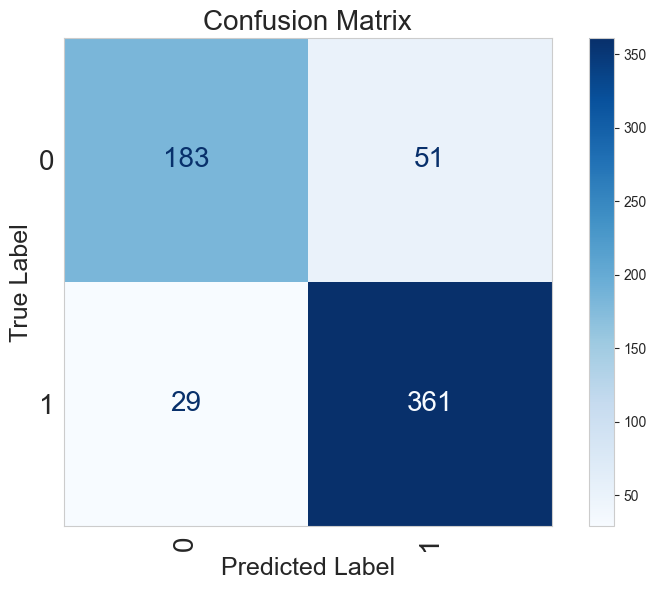

In [76]:
ds_test.reset()
predictions_pretrained_cv = model_pretrained_cv.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels_pretrained_cv = np.where(predictions_pretrained_cv>0.5, 1, 0)
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test_pretrained_cv = df_test['class'].copy().map(num_label).astype('int')
print("Test Accuracy Pretrained Model Validation: ", accuracy_score(Y_test_pretrained_cv, pred_labels_pretrained_cv))

print(metrics.classification_report(Y_test_pretrained_cv, pred_labels_pretrained_cv, labels = [0, 1]))

# Create ConfusionMatrixDisplay object
confusion_matrix = metrics.confusion_matrix(Y_test_pretrained_cv, pred_labels_pretrained_cv)

# Create ConfusionMatrixDisplay object
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)

# Plot the confusion matrix with increased text size
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(False)
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical', values_format='d')  # values_format='d' for integer formatting

# Set labels and title
plt.xlabel("Predicted Label", fontsize=18)
plt.ylabel("True Label", fontsize=18)
plt.title("Confusion Matrix", fontsize=20)

# Increase text size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for _, t in enumerate(ax.texts):
    t.set_fontsize(20)  # Adjust the font size here

plt.tight_layout()
plt.savefig('confusion_mtx_pretrained_cv.png')
plt.show()



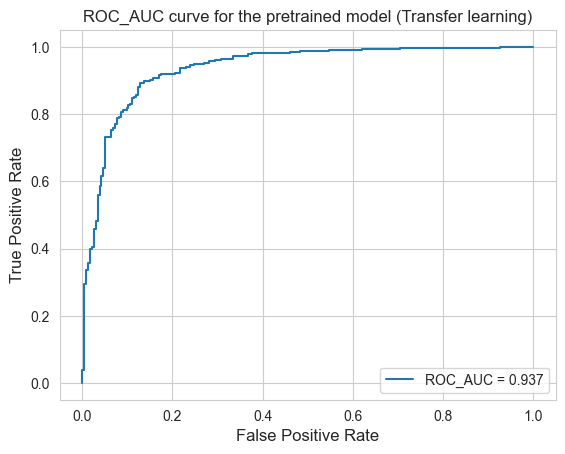

In [46]:
roc_auc = metrics.roc_auc_score(Y_test_pretrained_cv, predictions_pretrained_cv)

fpr, tpr, thresholds = metrics.roc_curve(Y_test_pretrained_cv, predictions_pretrained_cv)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.title(f'ROC_AUC curve for the pretrained model (Transfer learning)')
plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")
plt.savefig('ROC_no_cross_pretrained.png')
plt.show()

In [33]:
import pickle
model_pretrained_cv.save('model_pretrained_cv')

# Save the model to a file
with open('model_pretrained_cv.pkl', 'wb') as file:
    pickle.dump(model_pretrained_cv, file)

last_train_losses = [loss[-1] for loss in all_train_losses_p]
last_val_losses = [loss[-1] for loss in all_val_losses_p]
last_train_accuracies = [loss[-1] for loss in all_train_accuracies_p]
last_val_accuracies = [loss[-1] for loss in all_val_accuracies_p]

# Calculate the mean results
mean_train_loss = np.mean(last_train_losses)
mean_val_loss = np.mean(last_val_losses)
mean_train_accuracy = np.mean(last_train_accuracies)
mean_val_accuracy = np.mean(last_val_accuracies)

# Print the mean results
print("Mean Training Loss:", mean_train_loss)
print("Mean Validation Loss:", mean_val_loss)
print("Mean Training Accuracy:", mean_train_accuracy)
print("Mean Validation Accuracy:", mean_val_accuracy)


INFO:tensorflow:Assets written to: model_pretrained_cv/assets


INFO:tensorflow:Assets written to: model_pretrained_cv/assets


Mean Training Loss: 0.21683565080165862
Mean Validation Loss: 0.19651229977607726
Mean Training Accuracy: 0.9143025040626526
Mean Validation Accuracy: 0.9263800263404847


# Pre-trained Model without Cross Validation

In [37]:
#### WITHOUT CROSS VALIDATION (Pre-trained) ###
keras.backend.clear_session()

model_pretrained_no_cross = get_pretrained()
model_pretrained_no_cross.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained_no_cross.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [38]:
# Convert keys from strings to integers
class_weight_dict_int = {int(key): value for key, value in class_weight_dict.items()}
print(class_weight_dict_int)
history_no_cross = model_pretrained_no_cross.fit(ds_train,
          batch_size = BATCH, epochs = 20,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH),
        class_weight=class_weight_dict_int)

{0: 1.9448173005219984, 1: 0.6730322580645162}
Epoch 1/20
130/130 [==============================] - 645s 5s/step - loss: 0.5067 - binary_accuracy: 0.7354 - val_loss: 0.2672 - val_binary_accuracy: 0.9052 - lr: 5.0000e-05
Epoch 2/20
130/130 [==============================] - 631s 5s/step - loss: 0.3193 - binary_accuracy: 0.8636 - val_loss: 0.2105 - val_binary_accuracy: 0.9243 - lr: 5.0000e-05
Epoch 3/20
130/130 [==============================] - 630s 5s/step - loss: 0.2653 - binary_accuracy: 0.8897 - val_loss: 0.1902 - val_binary_accuracy: 0.9291 - lr: 5.0000e-05
Epoch 4/20
130/130 [==============================] - 629s 5s/step - loss: 0.2390 - binary_accuracy: 0.9099 - val_loss: 0.2245 - val_binary_accuracy: 0.9109 - lr: 5.0000e-05
Epoch 5/20
130/130 [==============================] - 630s 5s/step - loss: 0.2329 - binary_accuracy: 0.9099 - val_loss: 0.1875 - val_binary_accuracy: 0.9291 - lr: 5.0000e-05
Epoch 6/20
130/130 [==============================] - 632s 5s/step - loss: 0.2168 -

In [42]:
score = model_pretrained_no_cross.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])
score = model_pretrained_no_cross.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
ds_test.reset()
predictions_pretrained = model_pretrained_no_cross.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels_pretrained = np.where(predictions_pretrained>0.5, 1, 0)
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test_pretrained = df_test['class'].copy().map(num_label).astype('int')
# print("Test Accuracy: ", accuracy_score(Y_test_pretrained, pred_labels_pretrained))

print(metrics.classification_report(Y_test_pretrained, pred_labels_pretrained, labels = [0, 1]))

import pickle
model_pretrained_no_cross.save('model_pretrained_no_cross')

# Save the model to a file
with open('model_pretrained_no_cross.pkl', 'wb') as file:
    pickle.dump(model_pretrained_no_cross, file)

Val loss: 0.1332114189863205
Val accuracy: 0.9482758641242981
Test loss: 0.3045825660228729
Test accuracy: 0.8814102411270142
              precision    recall  f1-score   support

           0       0.91      0.76      0.83       234
           1       0.87      0.96      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.86      0.87       624
weighted avg       0.88      0.88      0.88       624

INFO:tensorflow:Assets written to: model_pretrained_no_cross/assets


INFO:tensorflow:Assets written to: model_pretrained_no_cross/assets


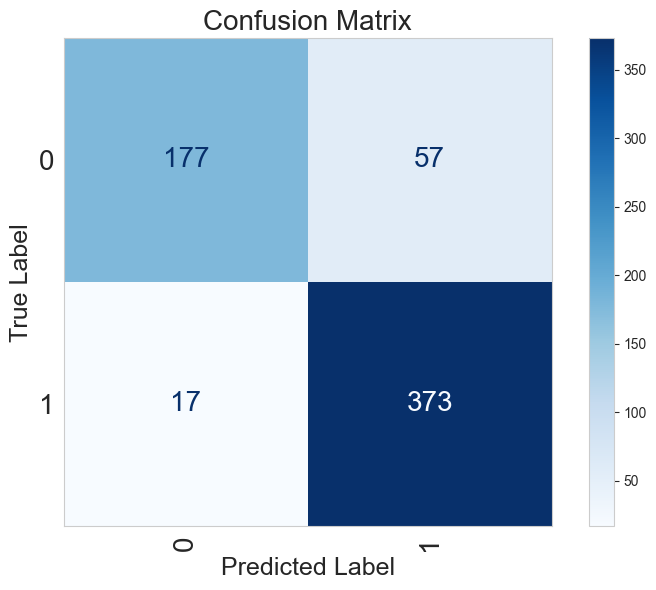

In [73]:
# Create ConfusionMatrixDisplay object
confusion_matrix = metrics.confusion_matrix(Y_test_pretrained, pred_labels_pretrained)

# Create ConfusionMatrixDisplay object
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)

# Plot the confusion matrix with increased text size
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(False)
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical', values_format='d')  # values_format='d' for integer formatting

# Set labels and title
plt.xlabel("Predicted Label", fontsize=18)
plt.ylabel("True Label", fontsize=18)
plt.title("Confusion Matrix", fontsize=20)

# Increase text size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for _, t in enumerate(ax.texts):
    t.set_fontsize(20)  # Adjust the font size here

plt.tight_layout()
plt.savefig('confusion_mtx_pretrained_nocross.png')
plt.show()


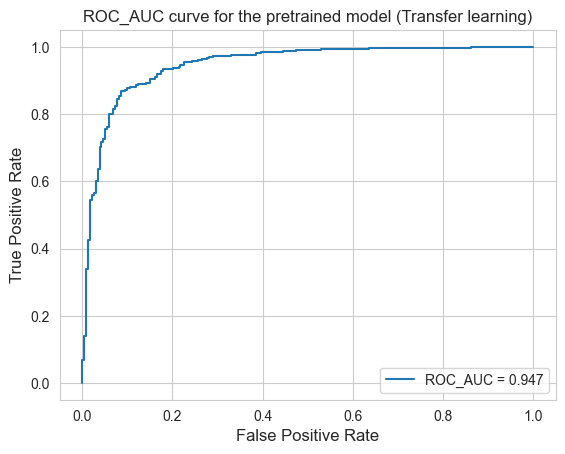

In [69]:
roc_auc = metrics.roc_auc_score(Y_test_pretrained, predictions_pretrained)

fpr, tpr, thresholds = metrics.roc_curve(Y_test_pretrained, predictions_pretrained)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.title(f'ROC_AUC curve for the pretrained model (Transfer learning)')
plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")
plt.savefig('ROC_no_cross_pretrained.png')
plt.show()

# 5-fold Cross Validation for SZANet

In [48]:
def get_model():

    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[inputs], outputs=output)

    return model

keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 16)      64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0     

In [49]:
from sklearn.model_selection import KFold
import numpy as np

# Initialize lists to store results
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

# Initialize KFold with 5 folds
kfold = KFold(n_splits=5, shuffle=True)

# Loop through each fold
for train_idx, val_idx in kfold.split(orig_train):
    train_fold = orig_train.iloc[train_idx]
    val_fold = orig_train.iloc[val_idx]
    
    # Prepare your datasets ds_train_fold and ds_val_fold from train_fold and val_fold
    ds_train_fold = train_datagen.flow_from_dataframe(train_fold,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

    ds_val_fold = val_datagen.flow_from_dataframe(val_fold,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)
    
    class_labels_cv = train_fold['class'].values

    # Get unique classes and their counts
    classes_cv, counts_cv = np.unique(class_labels_cv, return_counts=True)
    
    # Calculate class weights
    class_weights_cv = compute_class_weight('balanced', classes=classes_cv, y=class_labels_cv)
    class_weight_dict_cv = dict(zip(classes_cv, class_weights_cv))
    class_weight_dict_int = {int(key): value for key, value in class_weight_dict_cv.items()}

    history = model.fit(ds_train_fold,
                        batch_size=BATCH,
                        epochs=20,
                        validation_data=ds_val_fold,
                        callbacks=[early_stopping, plateau],
                        steps_per_epoch=(len(train_fold) / BATCH),
                        validation_steps=(len(val_fold) / BATCH),
                        class_weight=class_weight_dict_int
                       )
    
    # Store the losses and accuracies from each fold
    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_train_accuracies.append(history.history['binary_accuracy'])
    all_val_accuracies.append(history.history['val_binary_accuracy'])


Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Epoch 1/20
130/130 [==============================] - 203s 2s/step - loss: 0.5304 - binary_accuracy: 0.7538 - val_loss: 0.9116 - val_binary_accuracy: 0.7328 - lr: 5.0000e-05
Epoch 2/20
130/130 [==============================] - 194s 1s/step - loss: 0.2899 - binary_accuracy: 0.8720 - val_loss: 1.6450 - val_binary_accuracy: 0.7328 - lr: 5.0000e-05
Epoch 3/20
131/130 [==============================] - ETA: 0s - loss: 0.2666 - binary_accuracy: 0.8909
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
130/130 [==============================] - 201s 2s/step - loss: 0.2666 - binary_accuracy: 0.8909 - val_loss: 1.7802 - val_binary_accuracy: 0.7328 - lr: 5.0000e-05
Epoch 4/20
130/130 [==============================] - 202s 2s/step - loss: 0.2341 - binary_accuracy: 0.9082 - val_loss: 1.4150 - val_binary_accuracy: 0.7328 - lr: 1.0000e-05
Epoch 5/20
130

In [50]:
model.save('model_cv')
import pickle

# Save the model to a file
with open('model_cv.pkl', 'wb') as file:
    pickle.dump(model, file)

last_train_losses = [loss[-1] for loss in all_train_losses]
last_val_losses = [loss[-1] for loss in all_val_losses]
last_train_accuracies = [loss[-1] for loss in all_train_accuracies]
last_val_accuracies = [loss[-1] for loss in all_val_accuracies]

# Calculate the mean results
mean_train_loss = np.mean(last_train_losses)
mean_val_loss = np.mean(last_val_losses)
mean_train_accuracy = np.mean(last_train_accuracies)
mean_val_accuracy = np.mean(last_val_accuracies)

# Print the mean results
print("Mean Training Loss:", mean_train_loss)
print("Mean Validation Loss:", mean_val_loss)
print("Mean Training Accuracy:", mean_train_accuracy)
print("Mean Validation Accuracy:", mean_val_accuracy)

INFO:tensorflow:Assets written to: model_cv/assets


INFO:tensorflow:Assets written to: model_cv/assets


Mean Training Loss: 0.2045006275177002
Mean Validation Loss: 0.1562319278717041
Mean Training Accuracy: 0.9177532911300659
Mean Validation Accuracy: 0.9350085973739624


In [52]:
val_score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', val_score[0])
print('Val accuracy:', val_score[1])
test_score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])
ds_test.reset()
predictions_cv = model.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels_cv= np.where(predictions_cv >0.5, 1, 0)
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test_cv = df_test['class'].copy().map(num_label).astype('int')
# print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Val loss: 0.138143852353096
Val accuracy: 0.9406130313873291
Test loss: 0.436360239982605
Test accuracy: 0.8525640964508057


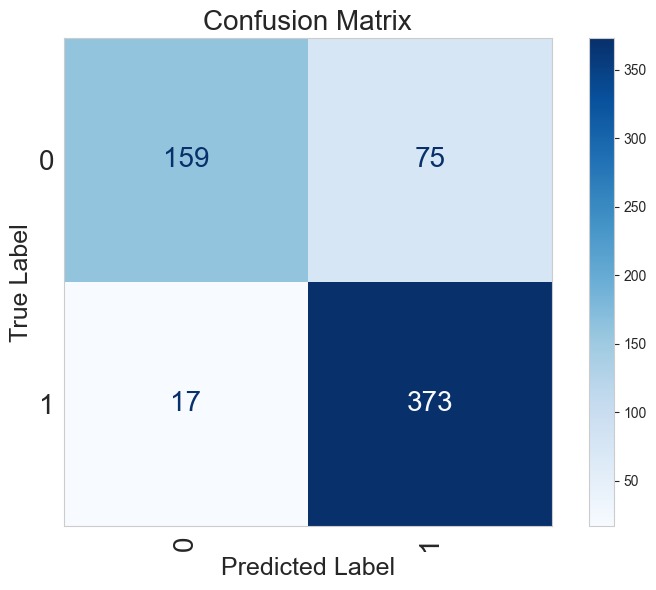

In [75]:
# Create ConfusionMatrixDisplay object
confusion_matrix = metrics.confusion_matrix(Y_test_cv, pred_labels_cv)

# Create ConfusionMatrixDisplay object
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)

# Plot the confusion matrix with increased text size
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(False)
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical', values_format='d')  # values_format='d' for integer formatting

# Set labels and title
plt.xlabel("Predicted Label", fontsize=18)
plt.ylabel("True Label", fontsize=18)
plt.title("Confusion Matrix", fontsize=20)

# Increase text size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for _, t in enumerate(ax.texts):
    t.set_fontsize(20)  # Adjust the font size here

plt.tight_layout()
plt.savefig('confusion_mtx_model_cv.png')
plt.show()


              precision    recall  f1-score   support

           0       0.90      0.68      0.78       234
           1       0.83      0.96      0.89       390

    accuracy                           0.85       624
   macro avg       0.87      0.82      0.83       624
weighted avg       0.86      0.85      0.85       624



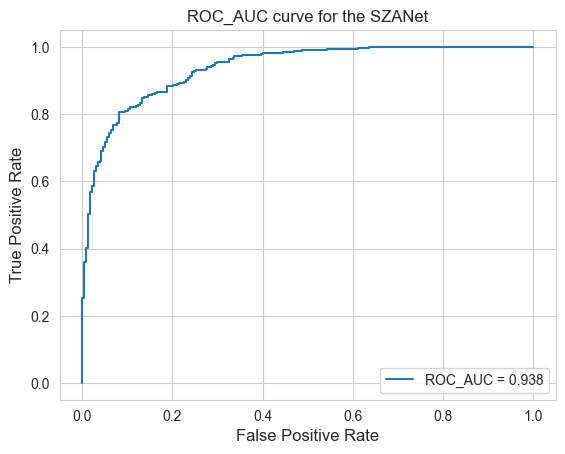

In [67]:
print(metrics.classification_report(Y_test_cv, pred_labels_cv, labels = [0, 1]))
roc_auc = metrics.roc_auc_score(Y_test_cv, predictions_cv)

fpr, tpr, thresholds = metrics.roc_curve(Y_test_cv, predictions_cv)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.title(f'ROC_AUC curve for the SZANet')
plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")
plt.savefig('ROC_no_cross_pretrained.png')
plt.show()

# SZANet without cross validation

In [61]:
#### WITHOUT CROSS VALIDATION (SZANet) ###
model_no_cv = get_model()
model_no_cv.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

class_weight_dict_int = {int(key): value for key, value in class_weight_dict.items()}
history = model_no_cv.fit(ds_train,
          batch_size = BATCH, epochs = 20,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH),
          class_weight=class_weight_dict_int);

Epoch 1/20
130/130 [==============================] - 204s 2s/step - loss: 0.6657 - binary_accuracy: 0.7148 - val_loss: 0.5841 - val_binary_accuracy: 0.7433 - lr: 5.0000e-05
Epoch 2/20
130/130 [==============================] - 215s 2s/step - loss: 0.3622 - binary_accuracy: 0.8526 - val_loss: 0.9382 - val_binary_accuracy: 0.7433 - lr: 5.0000e-05
Epoch 3/20
131/130 [==============================] - ETA: 0s - loss: 0.3104 - binary_accuracy: 0.8837
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
130/130 [==============================] - 190s 1s/step - loss: 0.3104 - binary_accuracy: 0.8837 - val_loss: 1.0652 - val_binary_accuracy: 0.7433 - lr: 5.0000e-05
Epoch 4/20
130/130 [==============================] - 200s 2s/step - loss: 0.2641 - binary_accuracy: 0.9044 - val_loss: 0.7693 - val_binary_accuracy: 0.7433 - lr: 1.0000e-05
Epoch 5/20
130/130 [==============================] - 205s 2s/step - loss: 0.2642 - binary_accuracy: 0.9044 - val_loss: 0.2539 - val_bin

In [62]:
# Save the model to a file
with open('model_no_cross.pkl', 'wb') as file:
    pickle.dump(model_no_cv, file)
model_no_cv.save('model_no_cross')

val_score = model_no_cv.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', val_score[0])
print('Val accuracy:', val_score[1])
test_score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])
ds_test.reset()
predictions = model_no_cv.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

INFO:tensorflow:Assets written to: model_no_cross/assets


INFO:tensorflow:Assets written to: model_no_cross/assets


Val loss: 0.1423151195049286
Val accuracy: 0.9578543901443481
Test loss: 0.4328951835632324
Test accuracy: 0.8525640964508057
Test Accuracy:  0.8269230769230769


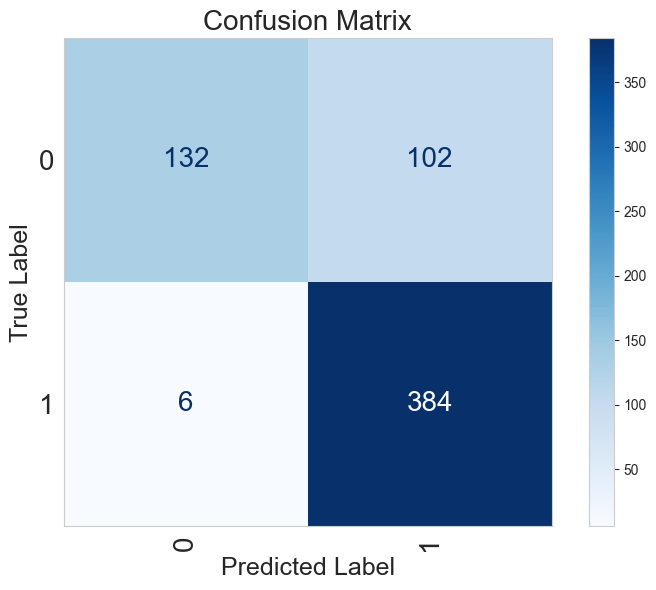

In [71]:
# Create ConfusionMatrixDisplay object
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)

# Create ConfusionMatrixDisplay object
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)

# Plot the confusion matrix with increased text size
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(False)
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical', values_format='d')  # values_format='d' for integer formatting

# Set labels and title
plt.xlabel("Predicted Label", fontsize=18)
plt.ylabel("True Label", fontsize=18)
plt.title("Confusion Matrix", fontsize=20)

# Increase text size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for _, t in enumerate(ax.texts):
    t.set_fontsize(20)  # Adjust the font size here

plt.tight_layout()
plt.savefig('confusion_mtx_model_nocross.png')
# plt.savefig('confusion_mtx_model_cv.png')
plt.show()


              precision    recall  f1-score   support

           0       0.96      0.56      0.71       234
           1       0.79      0.98      0.88       390

    accuracy                           0.83       624
   macro avg       0.87      0.77      0.79       624
weighted avg       0.85      0.83      0.81       624



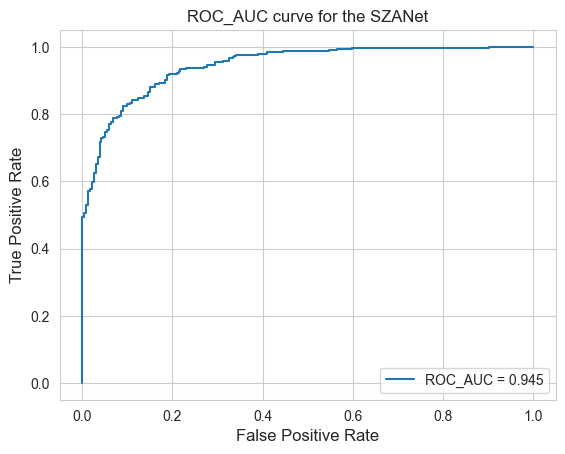

In [64]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))
roc_auc = metrics.roc_auc_score(Y_test, predictions)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.title(f'ROC_AUC curve for the SZANet')
plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")
# plt.savefig('ROC_no_cross_model.png')
plt.savefig('ROC_cv_model.png')
plt.show()

In [65]:
####Pruning####
import tensorflow as tf
import numpy as np
import keras
class_weight_dict_int = {int(key): value for key, value in class_weight_dict.items()}
print(class_weight_dict_int)
class PruningCallback(tf.keras.callbacks.Callback):
    def __init__(self, masks):
        super(PruningCallback, self).__init__()
        self.masks = masks  # Masks for pruning

    def on_epoch_end(self, epoch, logs=None):
        for layer, mask in zip(self.model.layers, self.masks):
            if mask is not None:
                weights, biases = layer.get_weights()
                weights *= mask  # Apply mask
                layer.set_weights([weights, biases])

def prune_weights(model, pruning_percentage):
    masks = []  # List to store masks
    for layer in model.layers:
        mask = None
        if isinstance(layer, (tf.keras.layers.Dense, tf.keras.layers.Conv2D)):
            weights, biases = layer.get_weights()
            abs_weights = np.abs(weights)
            threshold = np.percentile(abs_weights, pruning_percentage)
            mask = np.ones_like(weights)
            mask[abs_weights < threshold] = 0
            weights *= mask  # Apply mask
            layer.set_weights([weights, biases])
            masks.append(mask)
        else:
            masks.append(None)  # Non-prunable layer
    return model, masks

# model.save('model_no_cross')

accuracies = []
sparsities = []
scores =[]
best_score = 0
best_model = None

def calculate_sparsity(model):
    total_weights = np.sum([np.prod(w.shape) for w in model.get_weights()])
    zero_weights = np.sum([np.sum(w == 0) for w in model.get_weights()])
    return zero_weights / total_weights

# Iterative pruning
pruning_percentages = [30, 40, 50, 70, 80]

for percentage in pruning_percentages:
    # Load the original model
    model = tf.keras.models.load_model('model_no_cross')

    # Prune the model and get masks
    model_c, masks = prune_weights(model, percentage)

    # Create a pruning callback with the generated masks
    ###changed this line due to error
    pruning_callback = PruningCallback(masks)

    # Compile and retrain the model
    # model_c.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    #                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    #                 metrics=['accuracy'])
    model_c.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                     metrics=['accuracy'])
    model_c.fit(ds_train, batch_size=BATCH, epochs=3, validation_data=ds_val, callbacks=[pruning_callback], class_weight=class_weight_dict_int)

    # Calculate sparsity and evaluate the model
    sparsity = calculate_sparsity(model_c)
    accuracy = model_c.evaluate(ds_test, batch_size=BATCH)[1]
    score = (accuracy + sparsity) / 2 if accuracy > 0.6 and sparsity > 0 else 0
    # Store the results
    accuracies.append(accuracy)
    sparsities.append(sparsity)
    scores.append(score)

    if score > best_score:
      best_score = score
      best_model = tf.keras.models.clone_model(model_c)
      best_model.set_weights(model_c.get_weights())

# Print the results for each pruning percentage
for perc, acc, spar,sc in zip(pruning_percentages, accuracies, sparsities,scores):
    print(f"Pruning {perc}%: Accuracy = {acc}, Sparsity = {spar}, Score={sc}")


{0: 1.9448173005219984, 1: 0.6730322580645162}
Epoch 1/3
131/131 [==============================] - 207s 2s/step - loss: 0.0000e+00 - accuracy: 0.8166 - val_loss: 0.0000e+00 - val_accuracy: 0.8343
Epoch 2/3
131/131 [==============================] - 197s 2s/step - loss: 0.0000e+00 - accuracy: 0.8164 - val_loss: 0.0000e+00 - val_accuracy: 0.9119
Epoch 3/3
624/624 [==============================] - 17s 28ms/step - loss: 0.0000e+00 - accuracy: 0.8846
Epoch 1/3
131/131 [==============================] - 200s 2s/step - loss: 0.0000e+00 - accuracy: 0.6486 - val_loss: 0.0000e+00 - val_accuracy: 0.9128
Epoch 2/3
131/131 [==============================] - 198s 2s/step - loss: 0.0000e+00 - accuracy: 0.6400 - val_loss: 0.0000e+00 - val_accuracy: 0.9416
Epoch 3/3
624/624 [==============================] - 17s 28ms/step - loss: 0.0000e+00 - accuracy: 0.8558
Epoch 1/3
131/131 [==============================] - 201s 2s/step - loss: 0.0000e+00 - accuracy: 0.6299 - val_loss: 0.0000e+00 - val_accuracy: 

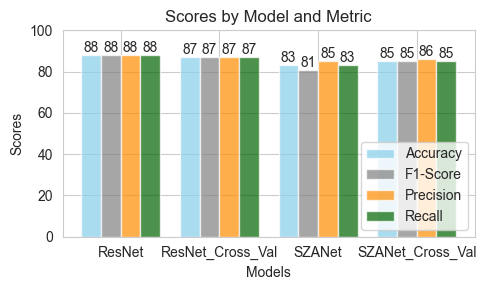

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the file into a DataFrame
data = pd.read_csv('model_accuracies.txt', delimiter='\t')

# Pivot the data to arrange metrics as columns for each model
pivot_data = data.pivot(index='Model', columns='Metric', values='Score')

# Define colors for each metric
colors = {'Accuracy': 'skyblue', 'Precision': 'darkorange', 'Recall': 'darkgreen', 'F1-Score': 'grey'}

# Plotting the bar plot
fig, ax = plt.subplots(figsize=(5, 3))

bar_width = 0.2
index = range(len(pivot_data))

# Iterate through metrics and plot bars for each model
for i, metric in enumerate(pivot_data.columns):
    bars = plt.bar(
        [x + (i * bar_width) for x in index],
        pivot_data[metric],
        color=colors[metric],
        label=metric,
        width=bar_width,
        alpha=0.7
    )

    # Annotate each bar with its corresponding score value
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 '%d' % int(bar.get_height()), ha='center', va='bottom')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Scores by Model and Metric')
plt.xticks([x + ((len(pivot_data.columns) - 1) * bar_width) / 2 for x in index], list(pivot_data.index))
plt.legend(loc='lower right')  # Move legend to the lower right corner
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('model_scores_barplot.png')
plt.show()
